# Potato Disease Classification

**Datasets credit**

Train and validation dataset:https://www.kaggle.com/arjuntejaswi/plant-village

Test dataset: https://www.kaggle.com/datasets/muhammadardiputra/potato-leaf-disease-dataset

## Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
from PIL import Image
import requests
from io import BytesIO

## Preprocessing the Dataset

### Importing the test data into tensorflow dataset object

In [94]:
test_data_dir='/content/drive/MyDrive/Potato/Test'
img_size=256
batch_size=32

test_ds=tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size=(img_size, img_size),
    batch_size=batch_size
)


Found 300 files belonging to 3 classes.


### Import data into tensorflow dataset object

In [2]:
data_dir='/content/drive/MyDrive/PlantVillage'
img_size=256
batch_size=32

In [3]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 2152 files belonging to 3 classes.
Using 1722 files for training.


In [4]:
val_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 2152 files belonging to 3 classes.
Using 430 files for validation.


In [5]:
class_names=train_ds.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

### Visualize some of the images from our dataset

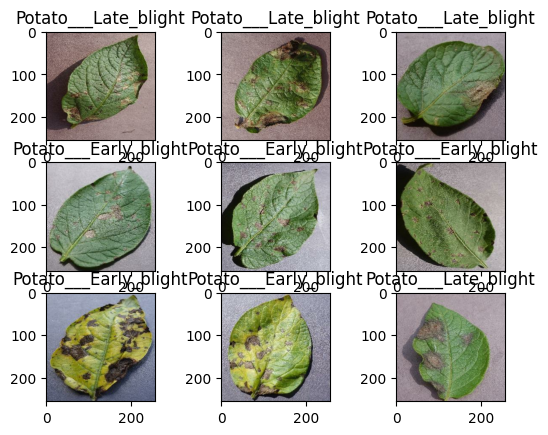

In [7]:
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])


### Cache, Shuffle, and Prefetch the Dataset

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Building the model

### Data Augmentation

In [9]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
])

In [10]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


### Create a model to resize and rescale the data

In [11]:
resize_rescalling=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(img_size,img_size,),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Model Architecture
Using a CNN coupled with a Softmax activation in the output layer.  also added the initial layers for resizing and normalization

In [14]:
input_shape=32,256,256,3
n_classes=3
Se_model=tf.keras.Sequential([
    resize_rescalling,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

Se_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Se_model.build(input_shape=input_shape)
Se_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

### Training the model

In [15]:
history=Se_model.fit(train_ds,
                     validation_data=val_ds,
                     epochs=50,
                     verbose=1
                     )

Epoch 1/50
54/54 [==============================] - 21s 328ms/step - loss: 0.9040 - accuracy: 0.4890 - val_loss: 0.9943 - val_accuracy: 0.5767
Epoch 2/50
54/54 [==============================] - 18s 333ms/step - loss: 0.7314 - accuracy: 0.6661 - val_loss: 0.7385 - val_accuracy: 0.7279
Epoch 3/50
54/54 [==============================] - 17s 319ms/step - loss: 0.6042 - accuracy: 0.7538 - val_loss: 0.5042 - val_accuracy: 0.8512
Epoch 4/50
54/54 [==============================] - 18s 324ms/step - loss: 0.4965 - accuracy: 0.8002 - val_loss: 0.4227 - val_accuracy: 0.8442
Epoch 5/50
54/54 [==============================] - 17s 322ms/step - loss: 0.3079 - accuracy: 0.8804 - val_loss: 0.2694 - val_accuracy: 0.9023
Epoch 6/50
54/54 [==============================] - 17s 308ms/step - loss: 0.2588 - accuracy: 0.9088 - val_loss: 0.3003 - val_accuracy: 0.8814
Epoch 7/50
54/54 [==============================] - 17s 311ms/step - loss: 0.2822 - accuracy: 0.8937 - val_loss: 0.2241 - val_accuracy: 0.9302

### Evaluating the model

In [96]:
Se_model.evaluate(test_ds)

10/10 [==============================] - 1s 62ms/step - loss: 0.0770 - accuracy: 0.9833


[0.07703787088394165, 0.9833333492279053]

98% accuracy on test dataset is pretty good
This means our model is ready

### Plotting the Accuracy and Loss Curves

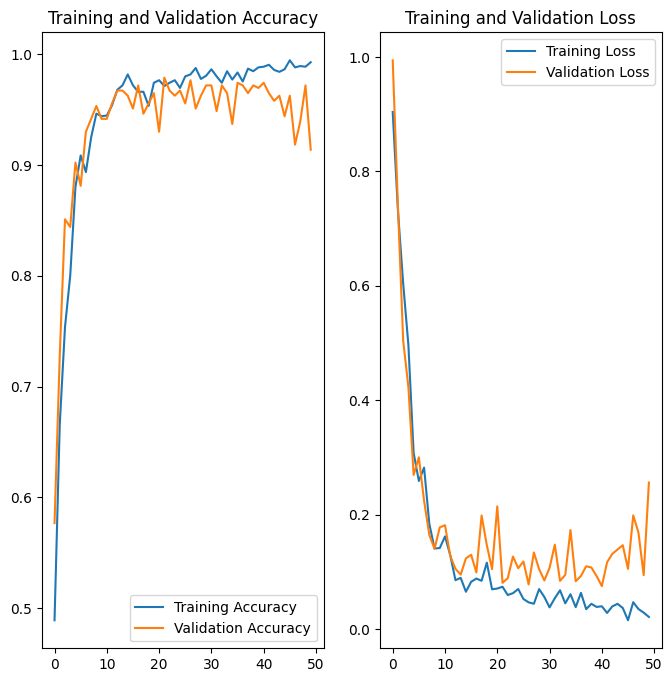

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Classification report and Confusion matrix

14/14 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       204
           1       0.97      0.95      0.96       197
           2       0.77      0.93      0.84        29

    accuracy                           0.97       430
   macro avg       0.91      0.96      0.93       430
weighted avg       0.97      0.97      0.97       430



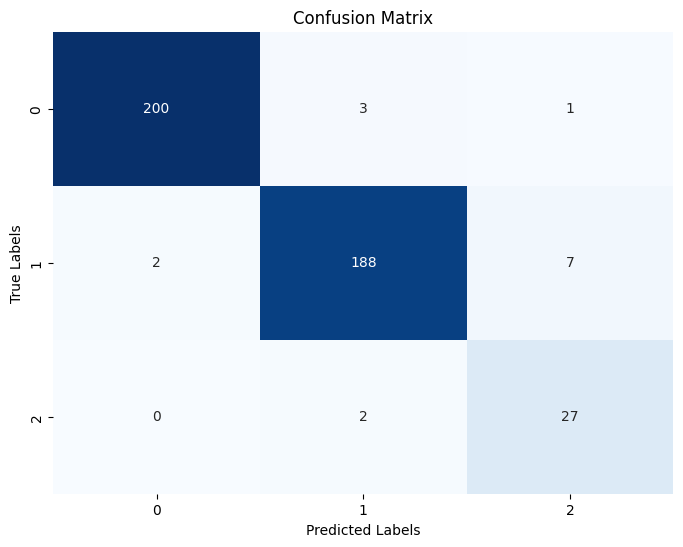

In [48]:
def get_true_labels(dataset):
    true_labels = []
    for _, labels in dataset:
        true_labels.extend(labels.numpy())  # Assuming labels are in NumPy arrays
    return true_labels

predicted_probs = Se_model.predict(val_ds)

predicted_labels = []
for row in predicted_probs:
    max_index = np.argmax(row)
    predicted_labels.append(max_index)
true_labels = get_true_labels(val_ds)

report = classification_report(true_labels, predicted_labels)
print(report)


classes = unique_labels(true_labels, predicted_labels)
confusion_mat = confusion_matrix(true_labels, predicted_labels, labels=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Predicting on Random images from the web

In [79]:
def predict_image_from_url(image_url):
  # Load the image from the URL
  response = requests.get(image_url)
  image = Image.open(BytesIO(response.content))

  # Convert the image to a NumPy array of pixel values
  pixel_values = np.array(image)
  plt.imshow(pixel_values)
  plt.axis('off')
  pixel_values = np.expand_dims(pixel_values, axis=0)


  prediction=Se_model.predict(pixel_values)
  prediction=np.argmax(prediction)
  prediction=class_names[prediction]
  print(f"predicted class is: {prediction}")
  return None

1/1 [==============================] - 0s 61ms/step
predicted class is: Potato___Early_blight


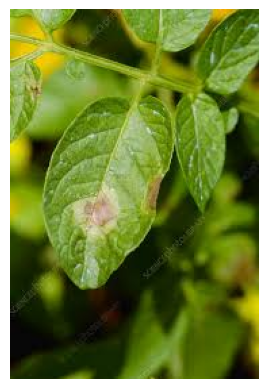

In [85]:
predict_image_from_url("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSXmA_PlvCin0VZgaQSTd1xMrlm9CnzybPiEw&usqp=CAU")

### Saving the trained model along with the weights

In [88]:
Se_model.save('potato classification model.h5')